# <center>Capstone Project - The Battle of Neighborhoods</center> 

## 1. Introduction

### 1.1 Background: Foursquare

Foursquare Labs Inc., commonly known as [Foursquare](https://foursquare.com/), is an American technology company. The company's location platform is the foundation of several business and consumer products, including the [Foursquare City Guide](https://foursquare.com/city-guide) and [Foursquare Swarm](https://www.swarmapp.com/) apps.
Foursquare built a massive dataset of location through crowd-sourcing their data and had people use their app to build their dataset and add venues and complete any missing information they had in their dataset. Communicating with the Foursquare
database is really very easy, all thanks to their RESTful API. You simply create a uniform resource identifier, or URI, and you append it with extra parameters depending on the data that you are seeking from the database. Any call request you make is composed of, we can call this base URI, which is _api.foursquare.com/v2_ and you can request data about venues, users, or tips. But, every time you make a call request, you have to pass your developer account credentials, which are your Client ID and Client Secret as well as what is called the version of the API, which is simply a date.

### 1.2 Background: Nottingham, UK

[Nottingham](https://en.wikipedia.org/wiki/Nottingham) is a city and unitary authority area in Nottinghamshire, England. Part of the East Midlands region, it is 128 miles (206 km) north of London and 45 miles (72 km) northeast of Birmingham.
<img src="https://previews.123rf.com/images/yurkaimmortal/yurkaimmortal1303/yurkaimmortal130300023/18386260-nottingham-england-skyline-city-silhouette.jpg"  width=400 height = 400/>

Nottingham has links to the legend of Robin Hood and to the lace-making, bicycle (notably Raleigh bikes) and tobacco industries. Nottingham is a popular tourist destination. In 2020, Nottingham had an estimated population of 330,000. The wider conurbation, which includes many of the city's suburbs, has a population of 768,638.

### 1.3 Business Problem

Nottinhgam city center is very lively with a wide offer of food and entrainment venues, while other areas of the city are also becoming more popular. However, historic data and observations in the city center suggest that there is a very high turn-over among newly opened venues and many of them shut relatively soon after opening. At the same time, there are several exmamples of venues in different categories that have become very successful and established.<br><br>
This poses a critical question for potential new owners and investors: **Is there any link between the area and the type of venue that will be successful?**

The target audience of this case study are existing and prospective new owners of restaurants, bars, arcades, food vans, snack shops and many other types of venues in the food and leisure industry. This case study can inform them which areas of Nottingham might be the best fit for opening their business ideas as well as where there is already a high concentration of similar business, such that there may be a stronger competition.

As a data science project, this case study may also reveal new insights from data, which have not been known and noticed before.

## 2. Data

### 2.1 Data acquisition and processing plan

A combination of different datasets will be used to explore the suggested business problem. In order to address the questions outlined in the previous section, a collection of data is required about:
- venue category or type
- its location
- how long it operated
- how popular it was or is

It is proposed to use Foursquare location, reviews and check-ins data to dervie the features above. The location data associated with venues can be obtained directly from the Foursquare dataset, which then can be used for spatial clustering. It is more challenging to evaluate how long a venue operatated, as it must be recognised that the venue may be __currently open and active__ or __already out of business and shut down__.

To deal with this problem, the following method is proposed:
1. Obtain the most recent review/check-in date for the venue - this is the **END DATE**
2. If this date is within the last 3 months, the venue is labelled as **ACTIVE**. If this date is older than the last 3 months, the venue is labelled as **INACTIVE**
3. Obtain the date when the venue was added to Foursquare - this is the **START DATE**
4. Calculate the differecene between the start date and the end date - this is the **OPERATION LENGTH**


The final part is to evaluate the how popular the vanues was or is. For this, the following values should be extracted:
1. Mean review score - this is the **RATING**
2. Total number of tips - this is the **REVIEWS** number. Note that ideally the number of check-ins would be used, but this is not available in the free version of Foursquare account

The other features are:
- **NAME**
- venue **TYPE**
- **LONGITUDE**
- **LATITUDE**

Therefore, the objective is to populate a dataframe, which will look like this:

In [1]:
# Code to generate an example dataframe
import pandas as pd
column_names = ['Name', 'Type', 'Latitude', 'Longitude', 'Status', 'StartDate', 'EndDate', 'Rating', 'Reviews'] 
venues = pd.DataFrame(columns=column_names)
venues = venues.append({'Name':'Example A', 'Type':'Restaurant', 'Latitude':52.125, 'Longitude':-1.487,
                        'Status':'ACTIVE', 'StartDate':pd.Timestamp(2017, 5, 4), 'EndDate':pd.Timestamp(2021, 3, 15),
                        'Rating': 4.6, 'Reviews':241}, ignore_index=True)
venues = venues.append({'Name':'Example B', 'Type':'Bar', 'Latitude':52.130, 'Longitude':-1.975,
                        'Status':'INACTIVE', 'StartDate':pd.Timestamp(2018, 10, 1), 'EndDate':pd.Timestamp(2019, 11, 30),
                        'Rating': 2.2, 'Reviews':148}, ignore_index=True)
venues


,Name,Type,Latitude,Longitude,Status,StartDate,EndDate,Rating,Reviews
0,Example A,Restaurant,52.125,-1.487,ACTIVE,2017-05-04,2021-03-15,4.6,241
1,Example B,Bar,52.130,-1.975,INACTIVE,2018-10-01,2019-11-30,2.2,148


The dataframe above shows two examples of the data that needs to be extraxcted from the Foursquare dataset for Nottingham.

### 2.2 Extracting data

### 2.2.1 Venues list

As the Foursquare location data will be used in this project, the first step is to obtain coordinates of Nottingham using **geopy** module.

In [2]:
from geopy.geocoders import Nominatim # Import the relevant library
address = 'Nottingham, UK'
location = Nominatim(user_agent="agent").geocode(address) # Retrieve the location object
print("Coordinates of Nottingham are: {} latitude and {} longitude".format(location.latitude, location.longitude))


Coordinates of Nottingham are: 52.9534193 latitude and -1.1496461 longitude


Set up Foursquare login details

In [1]:
# Foursquare credentials for authenticating API calls - removed from the shared notebook
CLIENT_ID = '' 
CLIENT_SECRET = '' 
ACCESS_TOKEN = '' 

Extract venues nearby the Nottingham coordindates, use 3 km radius. Initially, I only set the limit to 3 to check the json structure.

In [4]:
VERSION = '20200325'
LIMIT = 3
radius = 3000
url = 'https://api.foursquare.com/v2/venues/explore\
?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID,
                                                                            CLIENT_SECRET,
                                                                            location.latitude,
                                                                            location.longitude,
                                                                            VERSION,
                                                                            radius,
                                                                            LIMIT)

In [5]:
import requests
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6068af83774ed53612ded00d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Nottingham',
  'headerFullLocation': 'Nottingham',
  'headerLocationGranularity': 'city',
  'totalResults': 233,
  'suggestedBounds': {'ne': {'lat': 52.98041932700003,
    'lng': -1.104913783710233},
   'sw': {'lat': 52.92641927299997, 'lng': -1.194378416289767}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5448b19b498ec638a8a752da',
       'name': '200 Degrees Coffee',
       'location': {'address': 'Flying Horse Walk',
       

In [6]:
list(results.keys())

['meta', 'response']

In [7]:
list(results['response'].keys())

['suggestedFilters',
 'warning',
 'headerLocation',
 'headerFullLocation',
 'headerLocationGranularity',
 'totalResults',
 'suggestedBounds',
 'groups']

In [8]:
# This code gets me to the individual venue dictionary
results['response']['groups'][0]['items'][0]['venue']

{'id': '5448b19b498ec638a8a752da',
 'name': '200 Degrees Coffee',
 'location': {'address': 'Flying Horse Walk',
  'lat': 52.9531840289857,
  'lng': -1.1488877264147779,
  'labeledLatLngs': [{'label': 'display',
    'lat': 52.9531840289857,
    'lng': -1.1488877264147779}],
  'distance': 57,
  'cc': 'GB',
  'city': 'Nottingham',
  'state': 'Nottinghamshire',
  'country': 'United Kingdom',
  'formattedAddress': ['Flying Horse Walk',
   'Nottingham',
   'Nottinghamshire',
   'United Kingdom']},
 'categories': [{'id': '4bf58dd8d48988d1e0931735',
   'name': 'Coffee Shop',
   'pluralName': 'Coffee Shops',
   'shortName': 'Coffee Shop',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
    'suffix': '.png'},
   'primary': True}],
 'photos': {'count': 0, 'groups': []}}

Simplify the json structure:

In [9]:
results2 = results['response']['groups'][0]['items']

Check we can extract the relevant data:

In [10]:
for item in results2:
    print(item['venue']['id'])
    print(item['venue']['name'], end=', ')
    print(item['venue']['categories'][0]['name'])
    print(item['venue']['location']['lat'], end=',')
    print(item['venue']['location']['lng'])
    print('')

5448b19b498ec638a8a752da
200 Degrees Coffee, Coffee Shop
52.9531840289857,-1.1488877264147779

4b588c9af964a520685d28e3
Page 45, Bookstore
52.954103606755375,-1.1513676189116429

4bc9e8bcfb84c9b668dd1b3e
Aubrey's Traditional Creperie, Creperie
52.95426242827112,-1.1532410721145216



It looks like we can get the required information correctly. Therefore, now I'm going to run a full search for venues.

In [11]:
LIMIT = 1000
url = 'https://api.foursquare.com/v2/venues/explore\
?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID,
                                                                            CLIENT_SECRET,
                                                                            location.latitude,
                                                                            location.longitude,
                                                                            VERSION,
                                                                            radius,
                                                                            LIMIT)

In [12]:
fullresults = requests.get(url).json()

In [13]:
print('The total number of venues to work with is: '+str(fullresults['response']['totalResults']))

The total number of venues to work with is: 233


There is a total of 232 venues to work with in this project. I'm going populate a dataframe with the information about venues next.

In [14]:
venues_list = fullresults['response']['groups'][0]['items']

Extract and store the venues list into a dataframe

In [15]:
column_names = ['ID', 'Name', 'Type', 'Latitude', 'Longitude', 'Status', 'StartDate', 'EndDate', 'Rating', 'Reviews'] 
venues = pd.DataFrame(columns=column_names)

for item in venues_list:
    venues = venues.append({'ID':item['venue']['id'],
                            'Name':item['venue']['name'],
                            'Type':item['venue']['categories'][0]['name'],
                            'Latitude':item['venue']['location']['lat'],
                            'Longitude':item['venue']['location']['lng'],
                            'Status':None,
                            'StartDate':None,
                            'EndDate':None,
                            'Rating':None,
                            'Reviews':None}, ignore_index=True)

In [16]:
venues

,ID,Name,Type,Latitude,Longitude,Status,StartDate,EndDate,Rating,Reviews
0,5448b19b498ec638a8a752da,200 Degrees Coffee,Coffee Shop,52.953184,-1.148888,None,None,None,None,None
1,4b588c9af964a520685d28e3,Page 45,Bookstore,52.954104,-1.151368,None,None,None,None,None
2,4bc9e8bcfb84c9b668dd1b3e,Aubrey's Traditional Creperie,Creperie,52.954262,-1.153241,None,None,None,None,None
3,5377279f498ea7d99f33b627,Delilah,Deli / Bodega,52.953189,-1.146546,None,None,None,None,None
4,54514d19498e1bb54bc03834,Malt Cross,Bar,52.953068,-1.152378,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
95,4b979daaf964a520cb0b35e3,Royal Concert Hall,Concert Hall,52.955787,-1.151130,None,None,None,None,None
96,57dea566498e8c5236f06855,Heavenly Desserts,Dessert Shop,52.953836,-1.152724,None,None,None,None,None
97,4ba213aff964a52023da37e3,CookieShake,Café,52.955203,-1.148488,None,None,None,None,None
98,4ba640f7f964a520683f39e3,Albert Hall,Concert Hall,52.954316,-1.156111,None,None,None,None,None


It can be noted that there is only 100 items on the list. This is due to the limit on the number of venues returned by the call Foursqare API. In order to look for the remaining available venues, I am going to do a grid search around Nottingham and add any items that are not already in the dataframe.

In [17]:
radius = 500
import numpy as np
for lat in list(np.arange(52.925,52.995,0.01)):
    for lon in list(np.arange(-1.140,-1.120,0.01)):
        url = 'https://api.foursquare.com/v2/venues/explore\
?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID,
                                                                        CLIENT_SECRET,
                                                                        lat,
                                                                        lon,
                                                                        VERSION,
                                                                        radius,
                                                                        LIMIT)
        
        extraresults = requests.get(url).json()
        extraresults = extraresults['response']['groups'][0]['items']
        
        for item in extraresults:
            if item['venue']['id'] not in list(venues.ID):
                venues = venues.append({'ID':item['venue']['id'],
                            'Name':item['venue']['name'],
                            'Type':item['venue']['categories'][0]['name'],
                            'Latitude':item['venue']['location']['lat'],
                            'Longitude':item['venue']['location']['lng'],
                            'Status':None,
                            'StartDate':None,
                            'EndDate':None,
                            'Rating':None,
                            'Reviews':None}, ignore_index=True)
        

In [18]:
venues

,ID,Name,Type,Latitude,Longitude,Status,StartDate,EndDate,Rating,Reviews
0,5448b19b498ec638a8a752da,200 Degrees Coffee,Coffee Shop,52.953184,-1.148888,None,None,None,None,None
1,4b588c9af964a520685d28e3,Page 45,Bookstore,52.954104,-1.151368,None,None,None,None,None
2,4bc9e8bcfb84c9b668dd1b3e,Aubrey's Traditional Creperie,Creperie,52.954262,-1.153241,None,None,None,None,None
3,5377279f498ea7d99f33b627,Delilah,Deli / Bodega,52.953189,-1.146546,None,None,None,None,None
4,54514d19498e1bb54bc03834,Malt Cross,Bar,52.953068,-1.152378,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
242,53f8b835498e277704e0537f,The Abdication,Pub,52.998669,-1.137892,None,None,None,None,None
243,516bf133e4b0c17e610ac3f7,Arno Vale Recreation Ground,Park,52.994394,-1.124791,None,None,None,None,None
244,57f6e6fb498eacf298264432,A.C.E.S. Ltd,Other Repair Shop,52.991185,-1.131628,None,None,None,None,None
245,4e61fbd862e13e3bce6efa50,Arno Vale Play Park,Playground,52.993740,-1.123585,None,None,None,None,None


As seen above, now there are 236 venues to work with.

### 2.2.2 Ratings, reviews and dates

In order to retrieve further data, I am going to make a call to Foursquare API per every row in the venues dataframe and extract the venue details. Firstly, let's explore how the venue API works:

In [19]:
# Take an example venue
venueID = venues.loc[1,'ID']

In [20]:
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueID, CLIENT_ID, CLIENT_SECRET, VERSION)
# Retrieve example venue details
details = requests.get(url).json()
details

{'meta': {'code': 200, 'requestId': '6068af8c25fa6e064bba05a0'},
 'response': {'venue': {'id': '4b588c9af964a520685d28e3',
   'name': 'Page 45',
   'contact': {'phone': '+441159508045',
    'formattedPhone': '+44 115 950 8045',
    'twitter': 'pagefortyfive'},
   'location': {'address': '9 Market St',
    'lat': 52.954103606755375,
    'lng': -1.1513676189116429,
    'labeledLatLngs': [{'label': 'display',
      'lat': 52.954103606755375,
      'lng': -1.1513676189116429}],
    'postalCode': 'NG1 6HY',
    'cc': 'GB',
    'city': 'Nottingham',
    'state': 'Nottinghamshire',
    'country': 'United Kingdom',
    'formattedAddress': ['9 Market St',
     'Nottingham',
     'Nottinghamshire',
     'NG1 6HY',
     'United Kingdom']},
   'canonicalUrl': 'https://foursquare.com/v/page-45/4b588c9af964a520685d28e3',
   'categories': [{'id': '4bf58dd8d48988d114951735',
     'name': 'Bookstore',
     'pluralName': 'Bookstores',
     'shortName': 'Bookstore',
     'icon': {'prefix': 'https://ss3.4

In [21]:
details['response']['venue'].keys()

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'popular', 'seasonalHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])

In [22]:
details['response']['venue']['rating']

9.0

In [23]:
details['response']['venue']['createdAt']

1264094362

In [24]:
details['response']['venue']['stats']

{'tipCount': 7}

Loop through all the venus and populate additional info for each venue in the dataframe. Unfortunately, the free version of the API gives me only access to the 2 oldest tips, so I am not going to populate the end date at the moment.

In [25]:
for i in range(venues.shape[0]):
    venueID = venues.loc[i,'ID'] # Venue ID for the current row in the dataframe
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueID, CLIENT_ID, CLIENT_SECRET, VERSION)
    details = requests.get(url).json() # Retrieve data from the API
    
    try:
        venues.loc[i,'StartDate'] = pd.Timestamp(details['response']['venue']['createdAt'], unit='s') # Store the start date from the createdAt value
    except:
        venues.loc[i,'StartDate'] = np.NaN
        
    try:
        venues.loc[i,'Rating'] = details['response']['venue']['rating'] # Store the rating
    except:
        venues.loc[i,'Rating'] = np.NaN
    
    try:
        venues.loc[i,'Reviews'] = details['response']['venue']['stats']['tipCount'] # Store the count of reviews
    except:
        venues.loc[i,'Reviews'] = 0

In [26]:
venues

,ID,Name,Type,Latitude,Longitude,Status,StartDate,EndDate,Rating,Reviews
0,5448b19b498ec638a8a752da,200 Degrees Coffee,Coffee Shop,52.953184,-1.148888,None,2014-10-23 07:43:23,None,9.2,59
1,4b588c9af964a520685d28e3,Page 45,Bookstore,52.954104,-1.151368,None,2010-01-21 17:19:22,None,9.0,7
2,4bc9e8bcfb84c9b668dd1b3e,Aubrey's Traditional Creperie,Creperie,52.954262,-1.153241,None,2010-04-17 16:58:36,None,9.1,16
3,5377279f498ea7d99f33b627,Delilah,Deli / Bodega,52.953189,-1.146546,None,2014-05-17 09:10:55,None,8.8,9
4,54514d19498e1bb54bc03834,Malt Cross,Bar,52.953068,-1.152378,None,2014-10-29 20:24:57,None,8.7,11
...,...,...,...,...,...,...,...,...,...,...
242,53f8b835498e277704e0537f,The Abdication,Pub,52.998669,-1.137892,None,2014-08-23 15:50:13,None,NaN,1
243,516bf133e4b0c17e610ac3f7,Arno Vale Recreation Ground,Park,52.994394,-1.124791,None,2013-04-15 12:23:15,None,NaN,1
244,57f6e6fb498eacf298264432,A.C.E.S. Ltd,Other Repair Shop,52.991185,-1.131628,None,2016-10-07 00:06:19,None,NaN,0
245,4e61fbd862e13e3bce6efa50,Arno Vale Play Park,Playground,52.993740,-1.123585,None,2011-09-03 10:05:12,None,NaN,1


Because it's not possible to obtain the most recent review using free API, I am going to simulate it with random numbers, as this is only a case study for a course capstone project. I am going to find a random number, less than 145, corresponding to the number of days to go back from today (28/03/2021).

In [27]:
import random
random.seed(0) # For reproducibility
reference_date = pd.Timestamp(2021, 3, 28)

for i in range(venues.shape[0]):
    venues.loc[i,'EndDate'] = reference_date - pd.DateOffset(days=random.randrange(150)) # Assign a random date up to 150 days back from the reference date
    
venues

,ID,Name,Type,Latitude,Longitude,Status,StartDate,EndDate,Rating,Reviews
0,5448b19b498ec638a8a752da,200 Degrees Coffee,Coffee Shop,52.953184,-1.148888,None,2014-10-23 07:43:23,2020-12-20 00:00:00,9.2,59
1,4b588c9af964a520685d28e3,Page 45,Bookstore,52.954104,-1.151368,None,2010-01-21 17:19:22,2020-12-11 00:00:00,9.0,7
2,4bc9e8bcfb84c9b668dd1b3e,Aubrey's Traditional Creperie,Creperie,52.954262,-1.153241,None,2010-04-17 16:58:36,2021-03-18 00:00:00,9.1,16
3,5377279f498ea7d99f33b627,Delilah,Deli / Bodega,52.953189,-1.146546,None,2014-05-17 09:10:55,2021-01-21 00:00:00,8.8,9
4,54514d19498e1bb54bc03834,Malt Cross,Bar,52.953068,-1.152378,None,2014-10-29 20:24:57,2020-11-18 00:00:00,8.7,11
...,...,...,...,...,...,...,...,...,...,...
242,53f8b835498e277704e0537f,The Abdication,Pub,52.998669,-1.137892,None,2014-08-23 15:50:13,2020-12-16 00:00:00,NaN,1
243,516bf133e4b0c17e610ac3f7,Arno Vale Recreation Ground,Park,52.994394,-1.124791,None,2013-04-15 12:23:15,2020-12-12 00:00:00,NaN,1
244,57f6e6fb498eacf298264432,A.C.E.S. Ltd,Other Repair Shop,52.991185,-1.131628,None,2016-10-07 00:06:19,2021-01-07 00:00:00,NaN,0
245,4e61fbd862e13e3bce6efa50,Arno Vale Play Park,Playground,52.993740,-1.123585,None,2011-09-03 10:05:12,2021-03-28 00:00:00,NaN,1


The next step is to assigne the 'Status' label, where if the end date is within the last 3 months, then the status is ACTIVE and otherwise it should be INACTIVE

In [28]:
# Find the rows where the end date is after the reference date minus 3 months
flag_active = venues['EndDate'] > reference_date - pd.DateOffset(months=3)

In [29]:
# Assign values in the 'Status' column
venues.loc[flag_active,'Status'] = 'Active'
venues.loc[~flag_active,'Status'] = 'Inactive'
venues


,ID,Name,Type,Latitude,Longitude,Status,StartDate,EndDate,Rating,Reviews
0,5448b19b498ec638a8a752da,200 Degrees Coffee,Coffee Shop,52.953184,-1.148888,Inactive,2014-10-23 07:43:23,2020-12-20 00:00:00,9.2,59
1,4b588c9af964a520685d28e3,Page 45,Bookstore,52.954104,-1.151368,Inactive,2010-01-21 17:19:22,2020-12-11 00:00:00,9.0,7
2,4bc9e8bcfb84c9b668dd1b3e,Aubrey's Traditional Creperie,Creperie,52.954262,-1.153241,Active,2010-04-17 16:58:36,2021-03-18 00:00:00,9.1,16
3,5377279f498ea7d99f33b627,Delilah,Deli / Bodega,52.953189,-1.146546,Active,2014-05-17 09:10:55,2021-01-21 00:00:00,8.8,9
4,54514d19498e1bb54bc03834,Malt Cross,Bar,52.953068,-1.152378,Inactive,2014-10-29 20:24:57,2020-11-18 00:00:00,8.7,11
...,...,...,...,...,...,...,...,...,...,...
242,53f8b835498e277704e0537f,The Abdication,Pub,52.998669,-1.137892,Inactive,2014-08-23 15:50:13,2020-12-16 00:00:00,NaN,1
243,516bf133e4b0c17e610ac3f7,Arno Vale Recreation Ground,Park,52.994394,-1.124791,Inactive,2013-04-15 12:23:15,2020-12-12 00:00:00,NaN,1
244,57f6e6fb498eacf298264432,A.C.E.S. Ltd,Other Repair Shop,52.991185,-1.131628,Active,2016-10-07 00:06:19,2021-01-07 00:00:00,NaN,0
245,4e61fbd862e13e3bce6efa50,Arno Vale Play Park,Playground,52.993740,-1.123585,Active,2011-09-03 10:05:12,2021-03-28 00:00:00,NaN,1


### 2.3 Data cleaning and Feature generation

The data has now been fully extracted, so it can be further cleaned. Start with dropping the ID column, as this is no longer needed.

In [30]:
venues = venues.drop('ID',1)
venues

,Name,Type,Latitude,Longitude,Status,StartDate,EndDate,Rating,Reviews
0,200 Degrees Coffee,Coffee Shop,52.953184,-1.148888,Inactive,2014-10-23 07:43:23,2020-12-20 00:00:00,9.2,59
1,Page 45,Bookstore,52.954104,-1.151368,Inactive,2010-01-21 17:19:22,2020-12-11 00:00:00,9.0,7
2,Aubrey's Traditional Creperie,Creperie,52.954262,-1.153241,Active,2010-04-17 16:58:36,2021-03-18 00:00:00,9.1,16
3,Delilah,Deli / Bodega,52.953189,-1.146546,Active,2014-05-17 09:10:55,2021-01-21 00:00:00,8.8,9
4,Malt Cross,Bar,52.953068,-1.152378,Inactive,2014-10-29 20:24:57,2020-11-18 00:00:00,8.7,11
...,...,...,...,...,...,...,...,...,...
242,The Abdication,Pub,52.998669,-1.137892,Inactive,2014-08-23 15:50:13,2020-12-16 00:00:00,NaN,1
243,Arno Vale Recreation Ground,Park,52.994394,-1.124791,Inactive,2013-04-15 12:23:15,2020-12-12 00:00:00,NaN,1
244,A.C.E.S. Ltd,Other Repair Shop,52.991185,-1.131628,Active,2016-10-07 00:06:19,2021-01-07 00:00:00,NaN,0
245,Arno Vale Play Park,Playground,52.993740,-1.123585,Active,2011-09-03 10:05:12,2021-03-28 00:00:00,NaN,1


Find how long the venue operated using the difference between the end date and the start date. Store as a new column.

In [31]:
venues['DaysOperated'] = (venues['EndDate']-venues['StartDate']).dt.days
venues

,Name,Type,Latitude,Longitude,Status,StartDate,EndDate,Rating,Reviews,DaysOperated
0,200 Degrees Coffee,Coffee Shop,52.953184,-1.148888,Inactive,2014-10-23 07:43:23,2020-12-20 00:00:00,9.2,59,2249
1,Page 45,Bookstore,52.954104,-1.151368,Inactive,2010-01-21 17:19:22,2020-12-11 00:00:00,9.0,7,3976
2,Aubrey's Traditional Creperie,Creperie,52.954262,-1.153241,Active,2010-04-17 16:58:36,2021-03-18 00:00:00,9.1,16,3987
3,Delilah,Deli / Bodega,52.953189,-1.146546,Active,2014-05-17 09:10:55,2021-01-21 00:00:00,8.8,9,2440
4,Malt Cross,Bar,52.953068,-1.152378,Inactive,2014-10-29 20:24:57,2020-11-18 00:00:00,8.7,11,2211
...,...,...,...,...,...,...,...,...,...,...
242,The Abdication,Pub,52.998669,-1.137892,Inactive,2014-08-23 15:50:13,2020-12-16 00:00:00,NaN,1,2306
243,Arno Vale Recreation Ground,Park,52.994394,-1.124791,Inactive,2013-04-15 12:23:15,2020-12-12 00:00:00,NaN,1,2797
244,A.C.E.S. Ltd,Other Repair Shop,52.991185,-1.131628,Active,2016-10-07 00:06:19,2021-01-07 00:00:00,NaN,0,1552
245,Arno Vale Play Park,Playground,52.993740,-1.123585,Active,2011-09-03 10:05:12,2021-03-28 00:00:00,NaN,1,3493


In [32]:
venues.dtypes

Name             object
Type             object
Latitude        float64
Longitude       float64
Status           object
StartDate        object
EndDate          object
Rating           object
Reviews          object
DaysOperated      int64
dtype: object

In [33]:
print('Check the number of NaN days of operation:', str(sum(np.isnan(venues.loc[:,'DaysOperated']))))

Check the number of NaN days of operation: 0


Now let's drop the start date and end date. Also, convert reviews to float for the data modelling steps.

In [34]:
venues = venues.drop(['StartDate', 'EndDate'], 1)
venues = venues.astype({'Reviews': 'int64'})
venues

,Name,Type,Latitude,Longitude,Status,Rating,Reviews,DaysOperated
0,200 Degrees Coffee,Coffee Shop,52.953184,-1.148888,Inactive,9.2,59,2249
1,Page 45,Bookstore,52.954104,-1.151368,Inactive,9.0,7,3976
2,Aubrey's Traditional Creperie,Creperie,52.954262,-1.153241,Active,9.1,16,3987
3,Delilah,Deli / Bodega,52.953189,-1.146546,Active,8.8,9,2440
4,Malt Cross,Bar,52.953068,-1.152378,Inactive,8.7,11,2211
...,...,...,...,...,...,...,...,...
242,The Abdication,Pub,52.998669,-1.137892,Inactive,NaN,1,2306
243,Arno Vale Recreation Ground,Park,52.994394,-1.124791,Inactive,NaN,1,2797
244,A.C.E.S. Ltd,Other Repair Shop,52.991185,-1.131628,Active,NaN,0,1552
245,Arno Vale Play Park,Playground,52.993740,-1.123585,Active,NaN,1,3493


In [35]:
venues = venues.astype({'Rating': 'float64'})
print('Check the number of NaN ratings:', str(sum(np.isnan(venues['Rating']))))


Check the number of NaN ratings: 50


Finally, rearrange the columns of the dataframe and make sure the relevant columns are numeric.

In [36]:
venues.dtypes

Name             object
Type             object
Latitude        float64
Longitude       float64
Status           object
Rating          float64
Reviews           int64
DaysOperated      int64
dtype: object

In [37]:
venues = venues.loc[:,['Name', 'Type', 'Latitude', 'Longitude', 'DaysOperated', 'Reviews', 'Rating', 'Status']]
venues

,Name,Type,Latitude,Longitude,DaysOperated,Reviews,Rating,Status
0,200 Degrees Coffee,Coffee Shop,52.953184,-1.148888,2249,59,9.2,Inactive
1,Page 45,Bookstore,52.954104,-1.151368,3976,7,9.0,Inactive
2,Aubrey's Traditional Creperie,Creperie,52.954262,-1.153241,3987,16,9.1,Active
3,Delilah,Deli / Bodega,52.953189,-1.146546,2440,9,8.8,Active
4,Malt Cross,Bar,52.953068,-1.152378,2211,11,8.7,Inactive
...,...,...,...,...,...,...,...,...
242,The Abdication,Pub,52.998669,-1.137892,2306,1,NaN,Inactive
243,Arno Vale Recreation Ground,Park,52.994394,-1.124791,2797,1,NaN,Inactive
244,A.C.E.S. Ltd,Other Repair Shop,52.991185,-1.131628,1552,0,NaN,Active
245,Arno Vale Play Park,Playground,52.993740,-1.123585,3493,1,NaN,Active


## 3. Exploratory Data Analysis

### 3.1 All venues exploration

In [38]:
venues.describe(include='all')

,Name,Type,Latitude,Longitude,DaysOperated,Reviews,Rating,Status
count,247,247,247.000000,247.000000,247.000000,247.000000,197.000000,247
unique,232,100,NaN,NaN,NaN,NaN,NaN,2
top,Co-op Food,Pub,NaN,NaN,NaN,NaN,NaN,Active
freq,7,26,NaN,NaN,NaN,NaN,NaN,152
mean,NaN,NaN,52.954343,-1.140614,3150.757085,7.919028,7.598477,NaN
std,NaN,NaN,0.016055,0.009143,981.862746,11.904495,0.906354,NaN
min,NaN,NaN,52.922995,-1.162756,124.000000,0.000000,5.100000,NaN
25%,NaN,NaN,52.947604,-1.147016,2396.000000,1.000000,7.100000,NaN
50%,NaN,NaN,52.953556,-1.142904,3627.000000,3.000000,7.800000,NaN
75%,NaN,NaN,52.955869,-1.132785,3914.000000,10.000000,8.300000,NaN


In [39]:
pd.set_option('display.max_rows', None)
venues['Type'].value_counts()

Pub                       26
Bar                       17
Coffee Shop               12
Grocery Store             12
Indian Restaurant          9
Park                       8
Fast Food Restaurant       8
Café                       7
Cocktail Bar               5
Sandwich Place             5
Gym / Fitness Center       5
Italian Restaurant         5
Supermarket                4
Tapas Restaurant           4
Pizza Place                4
Furniture / Home Store     3
Brewery                    3
Restaurant                 3
Bookstore                  3
Deli / Bodega              3
Pharmacy                   3
Asian Restaurant           3
Music Venue                3
French Restaurant          3
Gym                        3
Dessert Shop               2
River                      2
Concert Hall               2
Bakery                     2
Movie Theater              2
Plaza                      2
Hookah Bar                 2
Arts & Crafts Store        2
Lounge                     2
Gastropub     

Let's show all venues on a map and include the details in the pop-ups. However, let's also color the markers according to the status of the venue.

In [40]:
import folium
# Generate map
map_1 = folium.Map(location=[location.latitude, location.longitude], zoom_start=14)

# Add venues as markers
for i in range(venues.shape[0]):
    label = venues.loc[i,'Name'] + '\n' + venues.loc[i,'Type'] + '\n' + 'Rating: ' + str(venues.loc[i,'Rating'])
    if venues.loc[i,'Status'] == 'Active':
        c = 'blue'
    else:
        c = 'red'
    
    folium.CircleMarker(
        [venues.loc[i,'Latitude'],venues.loc[i,'Longitude']],
        radius = 5,
        popup = folium.Popup(label),
        fill = True,
        fill_opacity=0.7,
        color = c,
        fill_color = c).add_to(map_1)


In [41]:
map_1


**<center>All venues shown on the map -  Active in blue, Inactive in red</center>**

### 3.2 Food venues analysis

In the next step, let's group the venues into more genric categories: Bar, Pub, Cafe, Restaurant, Deli. I'm going to also focus just on these types of venues in the later part of the study and skip all the other ones.

In [42]:
venues.insert(2,'Category','')

In [43]:
for i in range(venues.shape[0]):
    if venues.loc[i, 'Type'] in ['Bar','Lounge'] or 'Bar' in venues.loc[i, 'Type']:
        venues.loc[i, 'Category'] = 'Bar'
        
    elif venues.loc[i, 'Type'] in ['Pub','Brewery','Gastropub']:
        venues.loc[i, 'Category'] = 'Pub'
        
    elif venues.loc[i, 'Type'] in ['Pizza Place','Burger Joint','BBQ Joint','Wings Joint'] or 'Restaurant' in venues.loc[i, 'Type']:
        venues.loc[i, 'Category'] = 'Restaurant'
        
    elif venues.loc[i, 'Type'] in ['Sandwich Place','Deli / Bodega','Burrito Place','Fish & Chips Shop','Breakfast Spot','Creperie']:
        venues.loc[i, 'Category'] = 'Deli'
        
    elif venues.loc[i, 'Type'] in ['Coffe Shop', 'Coffee Shop', 'Café', 'Dessert Shop','Donut Shop','Pet Café','Tea Room']:
        venues.loc[i, 'Category'] = 'Cafe'
        
    else:
        venues.loc[i, 'Category'] = 'Other'

Let's create a separate dataframe for the venues in the chosen high-level categories

In [44]:
foodvenues = venues[venues['Category'] != 'Other']
foodvenues.shape

(147, 9)

In [45]:
print('Check the number of NaN ratings:', str(sum(np.isnan(foodvenues.loc[:,'Rating']))))

Check the number of NaN ratings: 15


As we can see, 12 out of 144 food venues miss any ratings. For the sake of the exercise and modelling, I am going to insert the average rating for these venues.

In [46]:
temp = np.isnan(foodvenues.loc[:,'Rating'])
temp = foodvenues.index[temp]

foodvenues.loc[temp, 'Rating'] = round(np.mean(foodvenues.Rating),1)
foodvenues

C:\Users\Maciek\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Name,Type,Category,Latitude,Longitude,DaysOperated,Reviews,Rating,Status
0,200 Degrees Coffee,Coffee Shop,Cafe,52.953184,-1.148888,2249,59,9.2,Inactive
2,Aubrey's Traditional Creperie,Creperie,Deli,52.954262,-1.153241,3987,16,9.1,Active
3,Delilah,Deli / Bodega,Deli,52.953189,-1.146546,2440,9,8.8,Active
4,Malt Cross,Bar,Bar,52.953068,-1.152378,2211,11,8.7,Inactive
6,Fox Cafe,Café,Cafe,52.953770,-1.147148,1982,8,8.7,Inactive
7,Five Guys,Burger Joint,Restaurant,52.953777,-1.150292,2126,11,8.6,Active
8,Wired Cafe Bar,Coffee Shop,Cafe,52.953556,-1.145667,2597,35,8.7,Inactive
10,Kigali,Coffee Shop,Cafe,52.953461,-1.143758,1563,14,8.9,Inactive
11,World Service,Restaurant,Restaurant,52.950793,-1.152312,3843,15,8.8,Active
12,Solo Grano,Italian Restaurant,Restaurant,52.952522,-1.149927,522,3,8.5,Inactive


In [47]:
foodvenues.reset_index(drop=True, inplace=True)



Let's explore the location of different categories of the venues. Firstly the Active ones, then Inactive ones.

In [48]:
# List of categories
cats = list(np.unique(foodvenues['Category']))

from matplotlib import cm
# Generate an aray of RGBA colors. There are as many colors as unique categories.
cols = cm.Set1(np.arange(len(cats)))

from matplotlib import colors
# Convert colors to hex
cols = [colors.rgb2hex(cols[i,:]) for i in range(cols.shape[0])]
cols

['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

In [49]:
# Generate map
map_2 = folium.Map(location=[location.latitude, location.longitude], zoom_start=14)

# Add venues as markers
for i in range(foodvenues.shape[0]):
    
    if foodvenues.loc[i,'Status'] == 'Inactive': 
        continue # Skip Inactive ones
    
    label = foodvenues.loc[i,'Name'] + '\n' + foodvenues.loc[i,'Type'] + '\n' + 'Rating: ' + str(foodvenues.loc[i,'Rating'])
    
    # Find the index of the category
    j = cats.index(foodvenues.loc[i,'Category'])
    
    # Assign the color based on the category
    c = cols[j]
    
    folium.CircleMarker(
        [foodvenues.loc[i,'Latitude'],foodvenues.loc[i,'Longitude']],
        radius = 5,
        popup = folium.Popup(label),
        fill = True,
        fill_opacity=0.7,
        color = c,
        fill_color = c).add_to(map_2)
    
map_2


**<center>ACTIVE food venues: red - Bar , orange - Restaurant, blue - Cafe , green - Deli , purple - Pub </center>**

In [50]:
# Generate map
map_3 = folium.Map(location=[location.latitude, location.longitude], zoom_start=14)

# Add venues as markers
for i in range(foodvenues.shape[0]):
    
    if foodvenues.loc[i,'Status'] == 'Active': 
        continue # Skip Active ones
    
    label = foodvenues.loc[i,'Name'] + '\n' + foodvenues.loc[i,'Type'] + '\n' + 'Rating: ' + str(foodvenues.loc[i,'Rating'])
    
    # Find the index of the category
    j = cats.index(foodvenues.loc[i,'Category'])
    
    # Assign the color based on the category
    c = cols[j]
    
    folium.CircleMarker(
        [foodvenues.loc[i,'Latitude'],foodvenues.loc[i,'Longitude']],
        radius = 5,
        popup = folium.Popup(label),
        fill = False,
        color = c,
        fill_color = c).add_to(map_3)
    
map_3


**<center>INACTIVE food venues: red - Bar , orange - Restaurant, blue - Cafe , green - Deli , purple - Pub </center>**

### 3.3 Relationships between parameters

In [51]:
# Set inline plotting and load seaborn
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

The following relationship plot shows all the features of the dataset in one go. The main purpose of the plot is to show the number of reviews vs. days operated, but additionally the status, rating and venue category.

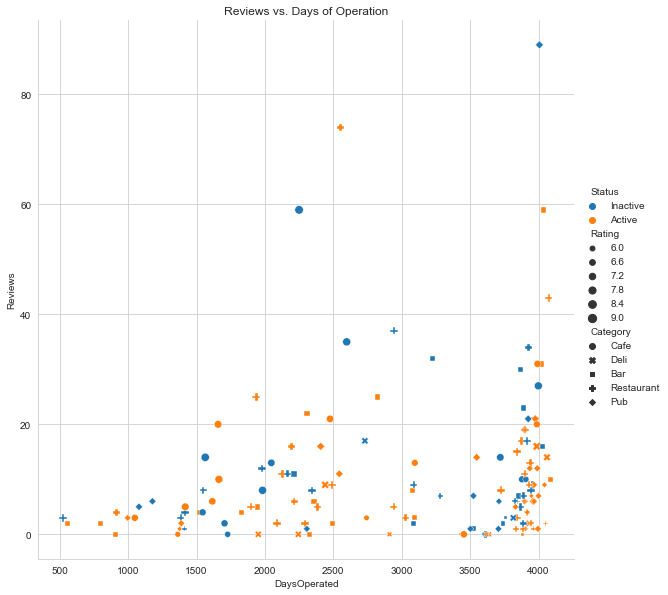

In [52]:
h1 = sns.relplot(data=foodvenues, x="DaysOperated", y="Reviews", hue="Status", style="Category", size="Rating", height=8)
h1.set(title='Reviews vs. Days of Operation');

As expected, some of the venues which operated for longer time have more reviews, but at the same time, there is a lot of venues that don't have many reviews. There seem to be no particular useful patterns to review. Let's ignore the status distinction as it was generated from artificial data.

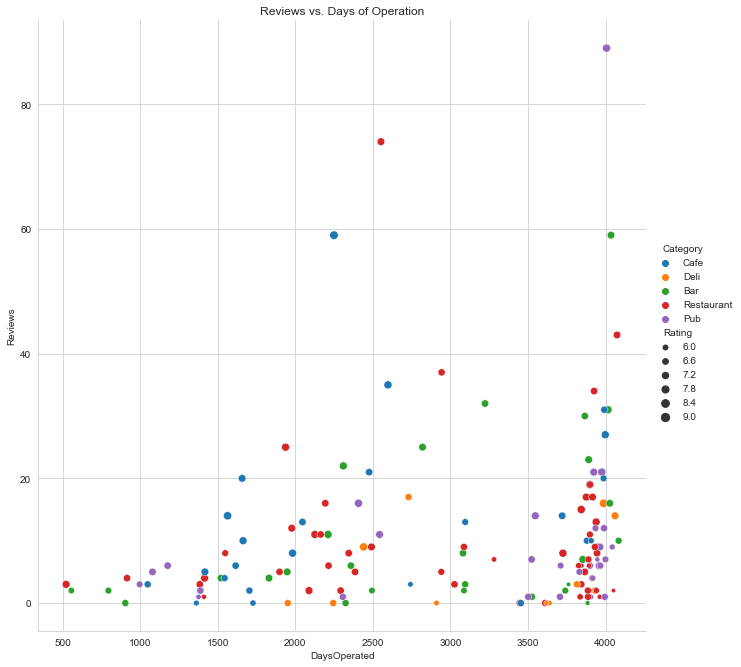

In [53]:
h2 = sns.relplot(data=foodvenues, x="DaysOperated", y="Reviews", hue="Category", size="Rating", height=9)
h2.set(title='Reviews vs. Days of Operation');

We can also review whether there is a link between the rating and the number of reviews. It could be the case that if the rating are very good, there are also more reivews.

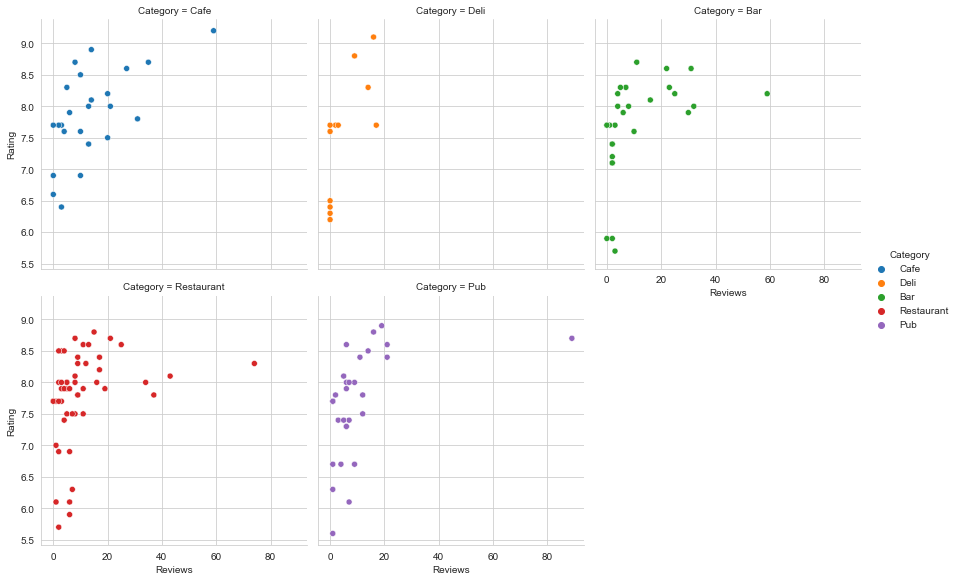

In [54]:
sns.relplot(data=foodvenues, x="Reviews", y="Rating", col="Category", hue="Category", height=4, col_wrap=3);

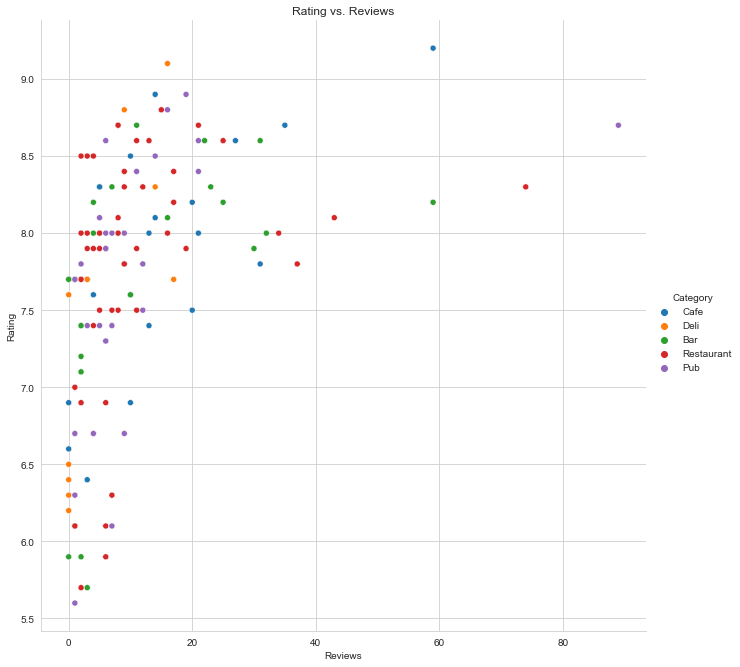

In [55]:
sns.relplot(data=foodvenues, x="Reviews", y="Rating", hue="Category", height=9).set(title='Rating vs. Reviews');

Indeed, from the above plots we can observe that the venues that have a lot of reviews also tend to have high ratings. This could suggest that if customers are particularyl satisfied they are also more likely to write a review. Another aspect to check is the rate of reviews.

In [56]:
foodvenues['ReviewsRate'] = foodvenues.Reviews/foodvenues.DaysOperated

<ipython-input-56-e5b56f2d39f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foodvenues['ReviewsRate'] = foodvenues.Reviews/foodvenues.DaysOperated


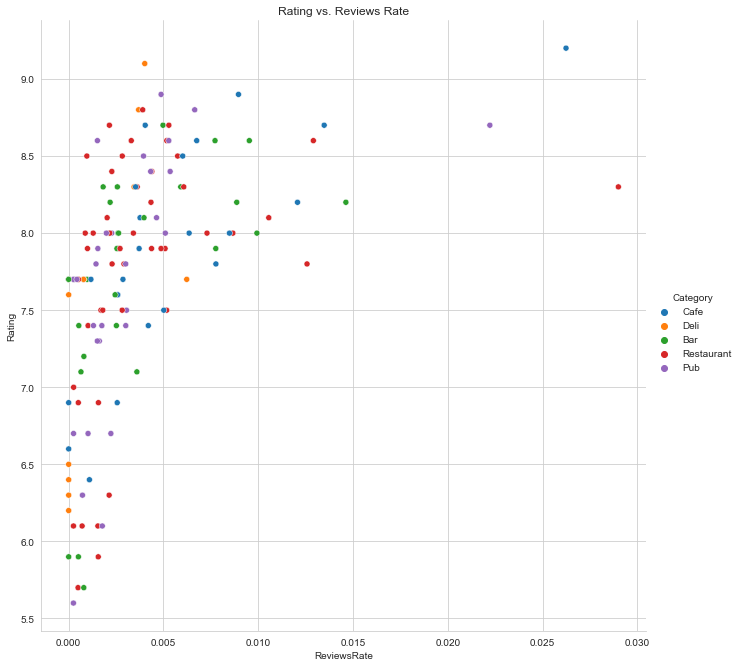

In [57]:
sns.relplot(data=foodvenues, x="ReviewsRate", y="Rating", hue="Category", height=9).set(title='Rating vs. Reviews Rate');

This confirm that in general the venues that receive very good ratings are also reviewed more frequently.

Let's now inspect the disributions of ratings for the Active and Inactive groups.

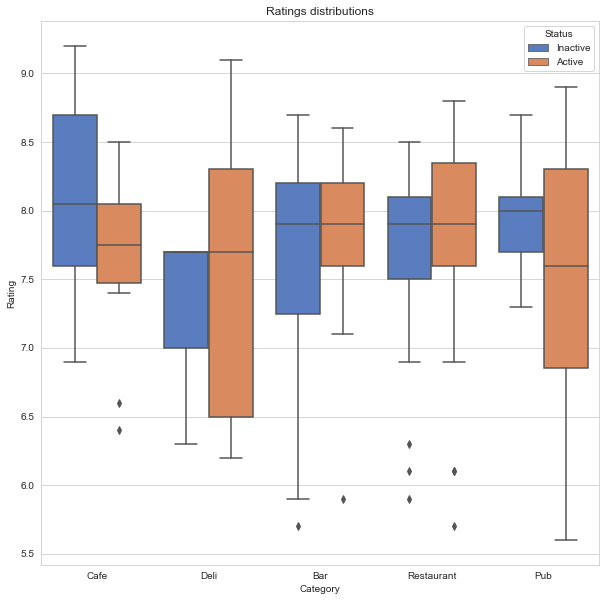

In [60]:
import matplotlib
f1 = matplotlib.pyplot.figure(figsize=[10,10])
sns.boxplot(data=foodvenues, x="Category", y="Rating", hue="Status", palette="muted").set(title='Ratings distributions');

In the boxplot above, there is no clear trend between the Active and Inactive venues. Again, this is probably due to the data being populated artificially. It could be expected that if we can access the real data on which venues are closed, the Inactive venues would have lower ratings that the ones that are still in busineess.

## 4. Predictive Modelling

For this case study, I am going to create a classifer to predict if a venue will be successful based on the location, category, rating and the rate of reviews. This would be a real, appropriate question to explore for the business problem stated at the start of the notebook. However, it should be noted that with some artificial input data, the modelling might not be capable or representattive of the true patterns.

In [61]:
foodvenues

,Name,Type,Category,Latitude,Longitude,DaysOperated,Reviews,Rating,Status,ReviewsRate
0,200 Degrees Coffee,Coffee Shop,Cafe,52.953184,-1.148888,2249,59,9.2,Inactive,0.026234
1,Aubrey's Traditional Creperie,Creperie,Deli,52.954262,-1.153241,3987,16,9.1,Active,0.004013
2,Delilah,Deli / Bodega,Deli,52.953189,-1.146546,2440,9,8.8,Active,0.003689
3,Malt Cross,Bar,Bar,52.953068,-1.152378,2211,11,8.7,Inactive,0.004975
4,Fox Cafe,Café,Cafe,52.953770,-1.147148,1982,8,8.7,Inactive,0.004036
5,Five Guys,Burger Joint,Restaurant,52.953777,-1.150292,2126,11,8.6,Active,0.005174
6,Wired Cafe Bar,Coffee Shop,Cafe,52.953556,-1.145667,2597,35,8.7,Inactive,0.013477
7,Kigali,Coffee Shop,Cafe,52.953461,-1.143758,1563,14,8.9,Inactive,0.008957
8,World Service,Restaurant,Restaurant,52.950793,-1.152312,3843,15,8.8,Active,0.003903
9,Solo Grano,Italian Restaurant,Restaurant,52.952522,-1.149927,522,3,8.5,Inactive,0.005747


### 4.1 Pre-process inputs

Extract the input columns

In [62]:
X = foodvenues[['Category', 'Latitude', 'Longitude', 'Rating', 'ReviewsRate']]

One-hot encode the category

In [63]:
X = pd.get_dummies(X)
features = X.columns
X

,Latitude,Longitude,Rating,ReviewsRate,Category_Bar,Category_Cafe,Category_Deli,Category_Pub,Category_Restaurant
0,52.953184,-1.148888,9.2,0.026234,0,1,0,0,0
1,52.954262,-1.153241,9.1,0.004013,0,0,1,0,0
2,52.953189,-1.146546,8.8,0.003689,0,0,1,0,0
3,52.953068,-1.152378,8.7,0.004975,1,0,0,0,0
4,52.953770,-1.147148,8.7,0.004036,0,1,0,0,0
5,52.953777,-1.150292,8.6,0.005174,0,0,0,0,1
6,52.953556,-1.145667,8.7,0.013477,0,1,0,0,0
7,52.953461,-1.143758,8.9,0.008957,0,1,0,0,0
8,52.950793,-1.152312,8.8,0.003903,0,0,0,0,1
9,52.952522,-1.149927,8.5,0.005747,0,0,0,0,1


Extract the targets

In [64]:
y = foodvenues[['Status']]
classes=np.unique(y)

temp = list(classes)
for i in range(len(temp)):
    y.replace(temp[i], i, inplace=True)
y   
   

C:\Users\Maciek\anaconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Status
0,1
1,0
2,0
3,1
4,1
5,0
6,1
7,1
8,0
9,1


In [65]:
X = X.values
y = y.values

### 4.2 Fit model

As the data is relatively limited, the cross-validation can be employed to assess the modelling accuracy. As the parameters correspond to very varied factors, decision trees might prove as a good modelling technique.

In [66]:
# Import sklearn libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# Prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=8, n_repeats=6)

In [67]:
# Set up and evaluate the 1st tree
tree1 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
scores = cross_val_score(tree1, X, y, scoring='accuracy', cv=cv)
print('Model accuracy: %.3f (+/-%.3f)' % (np.mean(scores), 3*np.std(scores)/scores.size))


Model accuracy: 0.540 (+/-0.007)


As seen above, the model accuracy over 6 evaluations of 8-fold validation is relatively poor. Different settings of the decision tree can be tried.

In [68]:
tree2 = DecisionTreeClassifier(criterion="gini", max_depth = 4)
scores = cross_val_score(tree2, X, y, scoring='accuracy', cv=cv)
print('Model accuracy: %.3f (+/-%.3f)' % (np.mean(scores), 3*np.std(scores)/scores.size))

Model accuracy: 0.523 (+/-0.006)


It looks like a very comparable accuracy was obtained using an algorithm with different settings. The modelling predictive capability is poor, not a great deal better than chance. This is likely due to the synthesized target values.

Finally, let's viusalise the tree classifier

In [69]:
tree = DecisionTreeClassifier(criterion="gini", max_depth = 4).fit(X,y)

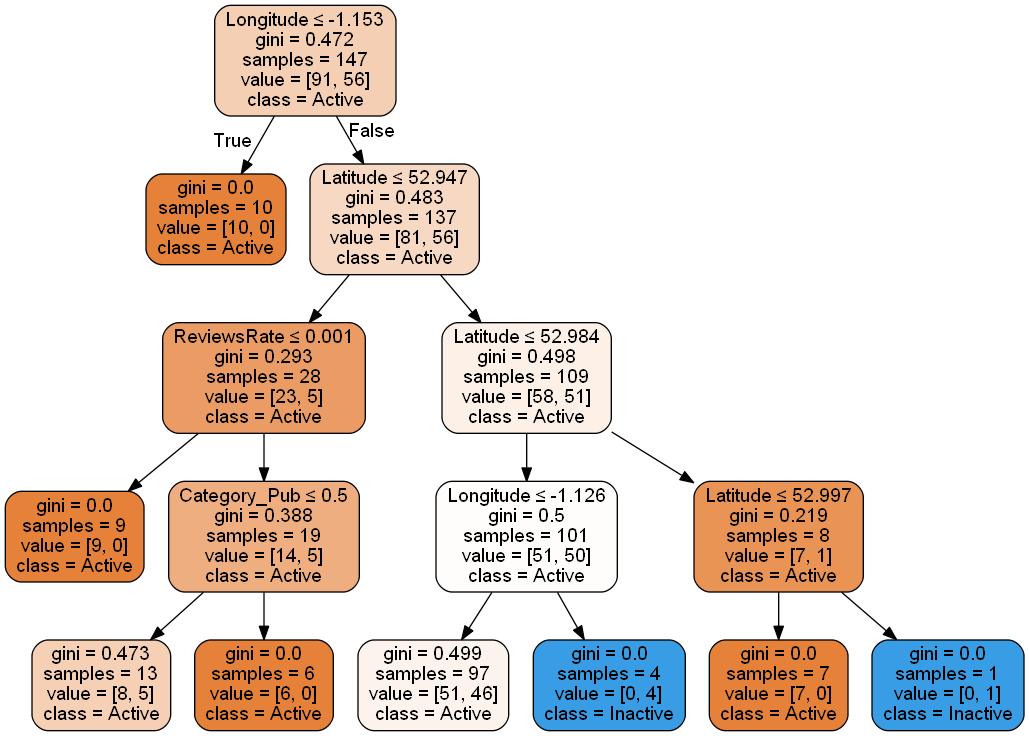

In [70]:
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image

out_file = StringIO()
export_graphviz(tree, feature_names=features, class_names=classes, 
               out_file=out_file,
               filled=True, rounded=True, special_characters=True)

graph = pydotplus.graph_from_dot_data(out_file.getvalue()) 
graph.write_png('tree.png')
Image(graph.create_png())

## 5. Summary

Nottingham food venues and other types of venues have been explored using Foursquare API and various data science techniques. Based on the mixture of the real and some synthesized data, there was no noticeable relation between the ratings of the venues and whether they are still in business or closed. The only clear trend was that where venues have high ratings, the reviews are also uploaded more often.
A decision tree classifer was created and evaluted to predict if a venue will close or stay open based on its location, category, ratings and review rates. In the current case study, the classifier showed very poor predictive accuracy.